In [1]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [2]:
pip install langdetect

In [3]:
pip install contractions

In [4]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
!pip install emoji
import emoji
import nltk
!pip install contractions
import contractions
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
!pip install langdetect
from langdetect import detect, LangDetectException
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
!pip install gensim
from gensim.models import Word2Vec

# Transformers library for BERT
!pip install transformers
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<ipython-input-4-67483aa00ea1>:67: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd

# File path in your Google Drive (adjust the path accordingly)
file_path = '/content/drive/My Drive/cyberbullying_tweets.csv'

# Read the CSV file using Pandas
df= pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [8]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [9]:
df.duplicated().sum()

36

In [10]:
df = df[~df.duplicated()]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [12]:
df.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

In [13]:
contractions.fix("can't")

'cannot'

In [14]:
text = 'I loved my familys'
words = word_tokenize(text)
lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

In [15]:
lemmatized_words

['I', 'loved', 'my', 'family']

In [16]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [17]:
import re

# Function to remove emojis using demojize
def remove_emoji(text):
    return emoji.demojize(text, delimiters=("", ""))

# Function to remove entities like mentions, hashtags, and links
def strip_all_entities(text):
    text = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+|https?://[^ ]+', '', text)
    return text

# Function to clean hashtags
def clean_hashtags(text):
    text = re.sub(r'#', '', text)
    return text

# Function to remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

# Function to remove short words (less than 3 characters)
def remove_short_words(text):
    return ' '.join(word for word in text.split() if len(word) > 2)

# Function to remove short tweets (less than 10 characters)
def remove_short_tweets(text):
    if len(text) > 10:
        return text
    else:
        return ''

# Applying the defined functions to clean the 'text' column
df['text_clean'] = df['text'].apply(remove_emoji)
df['text_clean'] = df['text_clean'].apply(strip_all_entities)
df['text_clean'] = df['text_clean'].apply(clean_hashtags)
df['text_clean'] = df['text_clean'].apply(remove_mult_spaces)
df['text_clean'] = df['text_clean'].apply(remove_short_words)
df['text_clean'] = df['text_clean'].apply(remove_short_tweets)


In [18]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,other words your food was crapilicious!
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore? more red velvet cupcakes?
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"meh. thanks for the heads up, but not too conc..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,This ISIS account pretending Kurdish account. ...


In [19]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 3341 duplicated tweets, we will remove them.


In [20]:
df.drop_duplicates("text_clean", inplace=True)

In [21]:
df.sentiment.value_counts()

religion               7961
age                    7951
ethnicity              7859
gender                 7540
not_cyberbullying      7373
other_cyberbullying    5631
Name: sentiment, dtype: int64

In [22]:
sentiments = ["religion","age","ethnicity","gender","other_cyberbullying","not bullying"]

In [23]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

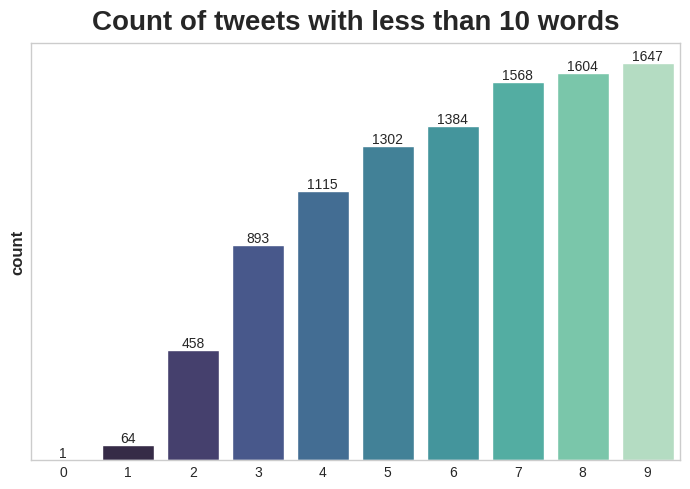

In [24]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [25]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
29205,is feminazi an actual word with a denot…\r\n@N...,other_cyberbullying,feminazi actual word with denot… job means pro...,553
24516,@NICKIMINAJ: #WutKinda\r\nAt this rate the MKR...,other_cyberbullying,"this rate the MKR final will December haha, ho...",497
30752,I don't retreat.\r\nyessssssss http://t.co/Td9...,other_cyberbullying,don't retreat. yessssssss Why they not make th...,363
44035,You so black and white trying to live like a n...,ethnicity,You black and white trying live like nigger......,243
33724,"... I don't feel guilty for killing him, I jus...",age,"... don't feel guilty for killing him, just fe...",220
...,...,...,...,...
3038,@informationchef @dannyo152 ❤️❤️,not_cyberbullying,red_heartred_heart,1
10282,Feminazi.....xD,gender,Feminazi.....xD,1
7001,"bully,,bully",not_cyberbullying,"bully,,bully",1
28855,💩,other_cyberbullying,pile_of_poo,1


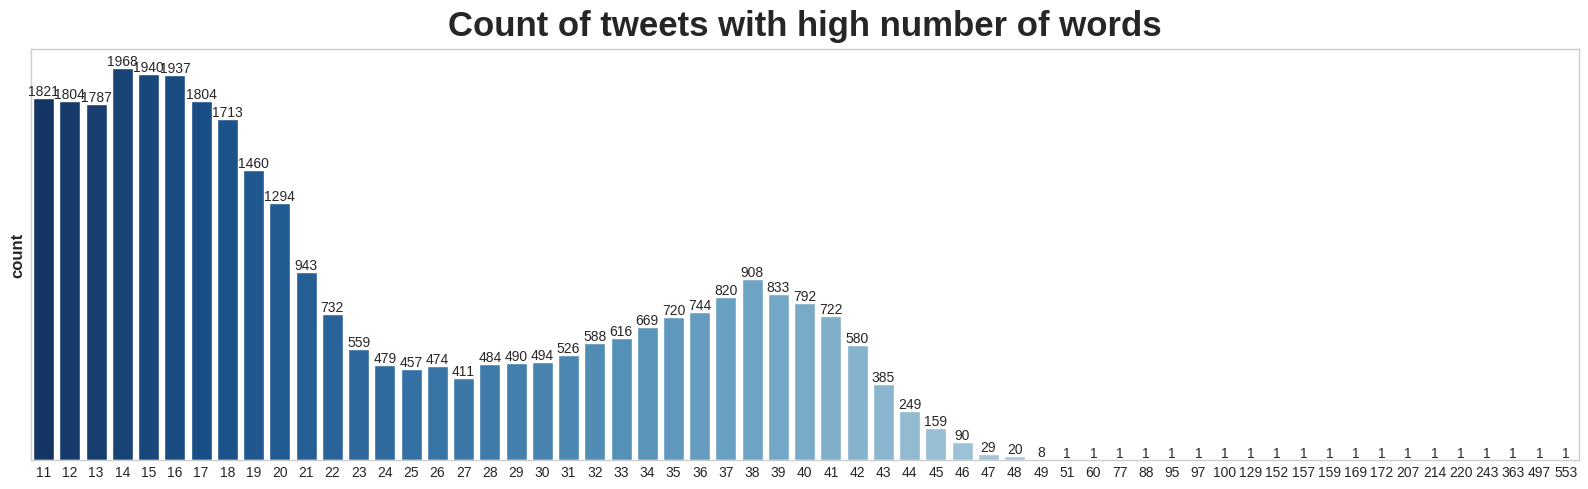

In [26]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [27]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [28]:
max_len = np.max(df['text_len'])
max_len

44

In [29]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
20183,This guys first tweet was 13 hours ago and now...,religion,This guys first tweet was hours ago and now th...,44
20754,[2] and then I'm doing it for my petty gain? W...,religion,[2] and then I'm doing for petty gain? Wow jus...,44
43845,I just walked past one oyinbo guy who was chil...,ethnicity,just walked past one oyinbo guy who was chilli...,44
39354,Edited: Idk why but i had a lucid dream about ...,age,Edited: Idk why but had lucid dream about and ...,44
13315,This whole ‘Trump and Putin are gay for each o...,gender,This whole ‘Trump and Putin are gay for each o...,44
...,...,...,...,...
1521,NOOOOOOOOOOOOOOO! #MKR,not_cyberbullying,NOOOOOOOOOOOOOOO!,1
30672,@lukemckinney 😊😇😘,other_cyberbullying,smiling_face_with_smiling_eyessmiling_face_wit...,1
27219,@jrinn siiiiiiiiiiiiiiiiiiiiiiiigh,other_cyberbullying,siiiiiiiiiiiiiiiiiiiiiiiigh,1
30812,@Lesbiologist 👍👍👯😘,other_cyberbullying,thumbs_upthumbs_uppeople_with_bunny_earsface_b...,1


In [30]:
df['sentiment'] = df['sentiment'].replace({
    'religion':0,
    'age':1,
    'ethnicity':2,
    'gender':3,
    'not_cyberbullying':4,
    'other_cyberbullying':5
})

In [31]:
X = df['text_clean']
y = df['sentiment']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [34]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5044],
       [   1, 5010],
       [   2, 4990],
       [   3, 4791],
       [   4, 4717],
       [   5, 3600]])

In [35]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [36]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [37]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5044],
       [   1, 5044],
       [   2, 5044],
       [   3, 5044],
       [   4, 5044],
       [   5, 5044]])